In [32]:
import dask.array as da
# visualize blob detections


blobs_zarr = 'out/results/sub-o21/micr/sub-o21_sample-brain_acq-prestitched_stain-{stain}_blobs.zarr'
spim_zarr = '/cifs/prado/Kate/AK_Pipeline_LSM/spimprep/bids/sub-o21/micr/sub-o21_sample-brain_acq-prestitched_SPIM.ome.zarr'

In [33]:
da_blobs = da.from_zarr(blobs_zarr.format(stain='BetaAmyloid'))

In [34]:
da_img = da.from_zarr(spim_zarr,component='/5')

In [35]:
da_blobs

dask.array<from-zarr, shape=(2159, 366, 232), dtype=int32, chunksize=(127, 122, 116), chunktype=numpy.ndarray>

In [36]:
da_img

dask.array<from-zarr, shape=(2, 2159, 366, 232), dtype=uint16, chunksize=(1, 1, 366, 232), chunktype=numpy.ndarray>

In [37]:
import matplotlib.pyplot as plt

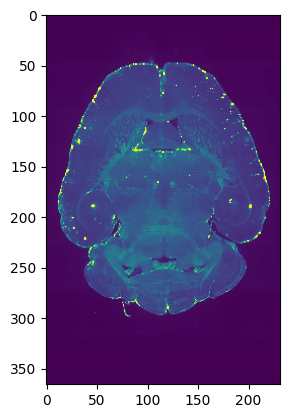

In [38]:
plt.imshow(da_img[1,1000,:,:],vmax=500)

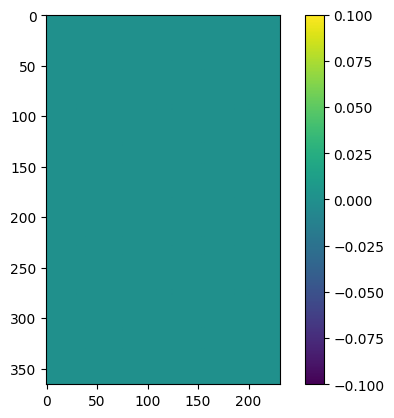

In [39]:
plt.imshow(da_blobs[1000,:,:])
plt.colorbar()

In [40]:
da_blobs.max().compute()

102

In [43]:
import nibabel as nib
import numpy as np

nib.Nifti1Image(da_img[1,800:1100,:,:].compute(),affine=np.eye(4)).to_filename('test_slice_BetaAmyloid.nii')
nib.Nifti1Image(da_blobs[800:1100,:,:].compute(),affine=np.eye(4)).to_filename('test_slice_BetaAmyloid_blobs.nii')



In [44]:
da_blobs

dask.array<from-zarr, shape=(2159, 366, 232), dtype=int32, chunksize=(127, 122, 116), chunktype=numpy.ndarray>

In [46]:
import sparse
s = da_blobs.map_blocks(sparse.COO)

In [55]:
sparse_arr = s.compute()
sparse_arr

Format,coo
Data Type,int32
Shape,"(2159, 366, 232)"
nnz,1844
Density,1.0058638590104411e-05
Read-only,True
Size,50.4K
Storage ratio,0.00


sparse._coo.core.COO

In [50]:
dense_arr = sparse_arr.to_dense()

AttributeError: 'COO' object has no attribute 'to_dense'

In [56]:
np.sum(sparse_arr>0)

1844

In [54]:
np.shape(sparse_arr)

(2159, 366, 232)

In [121]:
s = sparse.load_npz('out/results/sub-o21/micr/sub-o21_sample-brain_acq-prestitched_stain-BetaAmyloid_level-5_sparseblobs.npz')
s

Format,coo
Data Type,float32
Shape,"(2159, 366, 232, 4)"
nnz,7604
Density,1.0369561800319136e-05
Read-only,True
Size,267.3K
Storage ratio,0.00


In [124]:
(s[:,:,:,0].data)

102.0

In [ ]:
sparse_arr_loaded

In [102]:

x = np.random.random((100, 100, 100,1))
x[x < 0.9] = 0  # fill most of the array with zeros


s = sparse.COO(x)  # convert to sparse array

In [103]:

x2 = np.random.random((100, 100, 100,1))
x2[x < 0.9] = 0  # fill most of the array with zeros


s2 = sparse.COO(x2)  # convert to sparse array

In [111]:
s.data


array([0.96931082, 0.91506679, 0.95762133, ..., 0.93800311, 0.97371419,
       0.96831832])

In [110]:
s2.data


array([0.63367593, 0.13353512, 0.12586663, ..., 0.11144711, 0.83634647,
       0.94830573])

In [113]:
s_combined = sparse.COO(s.coords,(s.data,s2.data),shape=s.shape)

ValueError: data must be a scalar or 1-dimensional.

In [77]:
sparse_arr = sparse.load_npz('out/results/sub-o21/micr/sub-o21_sample-brain_acq-prestitched_stain-BetaAmyloid_level-3_sparseblobs.npz')

In [78]:
sparse_arr

Format,coo
Data Type,int32
Shape,"(2159, 1465, 931)"
nnz,40859
Density,1.3875472637001007e-05
Read-only,True
Size,1.1M
Storage ratio,0.00


In [81]:
sparse_arr.coords.shape

(3, 40859)

In [83]:
sparse_arr.coords.max(axis=1)

array([2157, 1324,  901])

In [98]:
import zarr

in_zarr = spim_zarr
zi = zarr.open(in_zarr)
attrs=zi['/'].attrs.asdict()

level=3

#read coordinate transform from ome-zarr
transforms = attrs['multiscales'][0]['datasets'][level]['coordinateTransformations']


#adjust sigma based on physical size of voxels 
scaling_zyx=np.array(transforms[0]['scale'][1:])
print(f'scaling_zyx: {scaling_zyx}') 
#mm per pixel

#multiply 
scaled_coords = sparse_arr.coords * scaling_zyx.reshape(3,1)

#save the coords to a numpy array
np.save('test_scaled_coords.npz',scaled_coords)


scaling_zyx: [0.004  0.0144 0.0144]


In [92]:
scaled_coords.shape

(3, 40859)

In [93]:
scaled_coords[:,0]

array([8.0000e-03, 1.0440e+01, 8.0208e+00])

In [95]:
sparse_arr.coords[:,0]

array([  2, 725, 557])

In [97]:
725*0.0144

10.44